# Transformer Experiments

## Packages and Presets

In [36]:

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import yaml
from icecream import ic


import matplotlib.pyplot as plt
import seaborn as sns   

from sklearn.metrics import (
    f1_score, 
    balanced_accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report
)
from torch.utils.data import Dataset, DataLoader, TensorDataset

from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE



pd.set_option('display.max_columns', None)
%load_ext blackcellmagic
%load_ext autoreload

The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

input_dim = 1  # x_train.shape[1]

hidden_dim = 128
layer_dim = 2
output_dim = 1

## Performance Evaluation

In [38]:
# Load data
ptbdb_train = pd.read_csv("../../data/ptbdb_train.csv", header=None)
ptbdb_test = pd.read_csv("../../data/ptbdb_test.csv", header = None)

In [39]:
x_train = ptbdb_train.iloc[:, :-1].values
y_train = ptbdb_train.iloc[:, -1].values

x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42
)

sm = SMOTE(random_state=42)
x_train, y_train = sm.fit_resample(x_train, y_train)


x_test = ptbdb_test.iloc[:, :-1].values
y_test = ptbdb_test.iloc[:, -1].values

# Convert data to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create TensorDatasets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

# Create DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [40]:
print(ptbdb_train.shape)
print(ptbdb_test.shape)

(11641, 188)
(2911, 188)


## Evaluating Model Performance

In [41]:
class LSTM(nn.Module):
    def __init__(
        self, input_dim, hidden_dim, layer_dim, output_dim, bidirectional=False
    ):
        super().__init__()
        self.input_dim = input_dim  # Size of the imput
        self.hidden_dim = hidden_dim  # Number ho hidden size
        self.layer_dim = layer_dim  # Number of hidden layer
        self.target_size = output_dim  # Number of size of the output
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=layer_dim,
            batch_first=False,
            dropout=0.2,
            bidirectional=bidirectional,
        )
        self.fc = nn.Sequential(
            nn.Linear(2 * (1 + bidirectional) * hidden_dim, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim),
        )

    def forward(self, input):
        # ic(input.shape)
        input = input.unsqueeze(2).permute(1, 0, 2)

        # ic(input.shape)
        out, _ = self.lstm(input)
        # pooled = self.pool(out.transpose(1, 2)).squeeze(-1)
        out = torch.concat([out.mean(dim=0), out.max(dim=0).values], dim=1)
        logits = self.fc(out)
        scores = F.sigmoid(logits)
        return scores

In [42]:
def test(
    model: nn.Module,
    test_loader: DataLoader,
    criterion: nn.Module,
    device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
) -> tuple[float, float, float]:
    test_loss = 0.0
    y_true = []
    y_pred = []
    model_probs = []
    with torch.no_grad():
        model.eval()
        for inputs, labels in test_loader:
            labels = labels.unsqueeze(1)
            y_true.extend(labels.numpy())
            logits = model(inputs.to(device))
            # logits = logits.detach().cpu().numpy().round().astype(int)
            # probs = F.sigmoid(logits)
            y_pred.extend(logits.detach().cpu().numpy().round().astype(int))
            # model_probs.extend(probs)
            # print(probs)
            # print(y_pred)
            # calculate validation loss
            loss = criterion(logits, labels.to(device))
            test_loss += loss.item()
            # avg valdation loss for epoch
        test_loss /= len(test_loader)
        # calculate validation f1 score and balanced accuracy
    f1 = f1_score(y_true, y_pred)
    bal_acc = balanced_accuracy_score(y_true, y_pred)

    print(f"Test Loss: {test_loss}")
    print(f"Test F1 Score: {f1}")
    print(f"Test Balanced Accuracy: {bal_acc}")

    return test_loss, y_pred, y_true

### Unidirectional LSTM:

In [43]:
model = model = LSTM(input_dim, hidden_dim, layer_dim, output_dim, bidirectional=False).to(
    DEVICE
)
model.load_state_dict(
    torch.load("../weights/lstm_unidirectional.pth", map_location=DEVICE)
)
model = model.to(DEVICE)

In [44]:
loss_function = nn.BCELoss()
optim = torch.optim.Adam(model.parameters(), lr=3e-4)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

test_loss, y_preds, y_true = test(model, test_loader, loss_function, DEVICE)

Test Loss: 0.03785322151025352
Test F1 Score: 0.9933269780743565
Test Balanced Accuracy: 0.9895378937476698


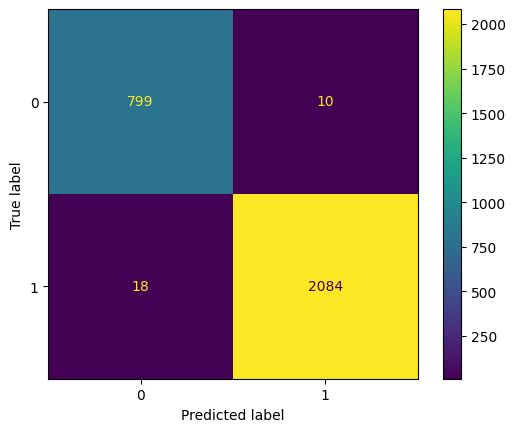

In [45]:
cm = confusion_matrix(y_true, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()

In [46]:
# calculate precision and recall:
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)

print(f"Test loss: {test_loss:.6f}")
print(f"Test accuracy: {accuracy_score(y_true, y_preds):.6f}")
print(f"Test balanced accuracy: {balanced_accuracy_score(y_true, y_preds):.6f}")
print(f"Test f1 score: {f1_score(y_true, y_preds):.6f}")
print(f"Test precision: {precision:.6f}")
print(f"Test recall: {recall:.6f}")

Test loss: 0.037853
Test accuracy: 0.990381
Test balanced accuracy: 0.989538
Test f1 score: 0.993327
Test precision: 0.995224
Test recall: 0.991437


In [47]:
print(classification_report(y_true, y_preds))

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98       809
         1.0       1.00      0.99      0.99      2102

    accuracy                           0.99      2911
   macro avg       0.99      0.99      0.99      2911
weighted avg       0.99      0.99      0.99      2911



## Bidirectional:

In [48]:
model = model = LSTM(input_dim, hidden_dim, layer_dim, output_dim, bidirectional=True).to(
    DEVICE
)
model.load_state_dict(
    torch.load("../weights/lstm_bidirectional.pth", map_location=DEVICE)
)
model = model.to(DEVICE)

In [49]:
loss_function = nn.BCELoss()
optim = torch.optim.Adam(model.parameters(), lr=3e-4)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

test_loss, y_preds, y_true = test(model, test_loader, loss_function, DEVICE)

Test Loss: 0.12287476200372507
Test F1 Score: 0.995249406175772
Test Balanced Accuracy: 0.9903003084942352


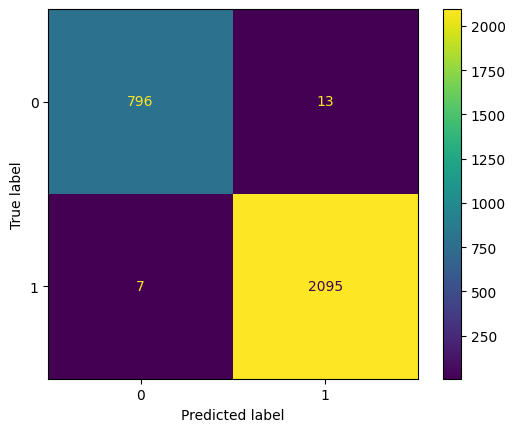

In [50]:
cm = confusion_matrix(y_true, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()

In [51]:
# calculate precision and recall:
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)

print(f"Test loss: {test_loss:.6f}")
print(f"Test accuracy: {accuracy_score(y_true, y_preds):.6f}")
print(f"Test balanced accuracy: {balanced_accuracy_score(y_true, y_preds):.6f}")
print(f"Test f1 score: {f1_score(y_true, y_preds):.6f}")
print(f"Test precision: {precision:.6f}")
print(f"Test recall: {recall:.6f}")

Test loss: 0.122875
Test accuracy: 0.993130
Test balanced accuracy: 0.990300
Test f1 score: 0.995249
Test precision: 0.993833
Test recall: 0.996670


In [52]:
print(classification_report(y_true, y_preds))

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99       809
         1.0       0.99      1.00      1.00      2102

    accuracy                           0.99      2911
   macro avg       0.99      0.99      0.99      2911
weighted avg       0.99      0.99      0.99      2911

